<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

Yining Feng

MSDS 453 Natural Language Processing <br>
Final Project <br>
Due: 3/17/2021 <br>

## Aspect-based Sentiment Analysis

In [1]:
!pip3 install spacy_universal_sentence_encoder
!pip install spacy-universal-sentence-encoder[multi]
!python -m spacy download en
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 12.8MB 309kB/s 
     |████████████████████████████████| 460kB 42.2MB/s 
     |████████████████████████████████| 9.1MB 42.3MB/s 
     |████████████████████████████████| 1.1MB 49.0MB/s 
     |████████████████████████████████| 122kB 36.5MB/s 
  Created wheel for spacy-universal-sentence-encoder: filename=spacy_universal_sentence_encoder-0.4.0-cp37-none-any.whl size=11625 sha256=564a325452e01a07b3a5b9a6a1101b522539d14d332291e410e330c1e5714ce8
  Stored in directory: /root/.cache/pip/wheels/46/79/fe/967c2ddd34acf90979a157a825ca16c83f443252ea588e44b4
  Created wheel for smart-open: filename=smart_open-3.0.0-cp37-none-any.whl size=107098 sha256=6509b67f7b2e1b5e6e5f70dd8d274482210b524440783a8e5d9dfee57fb1af61
  Stored in directory: /root/.cache/pip/wheels/18/88/7c/f06dabd5e9cabe02d2269167bcacbbf9b47d0c0ff7d6ebcb78
Successfully built spacy-universal-sentence-encoder smart-open
  Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:

In [2]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

import spacy
import pandas as pd
import os
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import ngrams, FreqDist
import spacy_universal_sentence_encoder

In [3]:
#functions used to process text and create the required TFIDF and Doc2vec Matrices
def remove_punctuation(in_text):
    # Remove punctuation
    text = re.sub('[^a-zA-Z]', ' ', str(in_text))
    return text

# Pre-process dataset to lower case it
def lower_case(in_text):
    # Convert to lowercase
    text = in_text.lower()    
    return text

# Pre-process dataset to remove special characters and digits
def remove_special_chars_and_digits(in_text):
    # Remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",in_text)
    return text

# Pre-process dataset to remove tags
def remove_tags(in_text):    
    # Remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",in_text)
    return text
# Remove stop words
def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = "" 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence = filtered_sentence + " "+ w

    return filtered_sentence

def clean_doc(text):
    text = remove_punctuation(text)
    text = remove_special_chars_and_digits(text)
    text = lower_case(text)
    return text

In [154]:
from google.colab import files

uploaded = files.upload()

Saving sentiment.csv to sentiment.csv


## Build Ontology

In [26]:
import pandas as pd
import re
from spacy.lang.en import English

text = list(data['Text'])
text = ''.join(text)

nlp = spacy.load('en_core_web_lg')


def get_entity_pairs(text):
    # preprocess text
    text = re.sub(r'\n+', '.', text)  # replace multiple newlines with period
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers
    text = re.sub(r'^https?:\/\/<>.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = nlp(text)

    def refine_ent(ent, sent):
        unwanted_tokens = (
            'PRON',  # pronouns
            'PART',  # particle
            'DET',  # determiner
            'SCONJ',  # subordinating conjunction
            'PUNCT',  # punctuation
            'SYM',  # symbol
            'X',  # other
        )
        ent_type = ent.ent_type_  # get entity type
        if ent_type == '':
            ent_type = 'NOUN_CHUNK'
            ent = ' '.join(str(t.text) for t in
                           nlp(str(ent)) if t.pos_
                           not in unwanted_tokens and t.is_stop == False)
        elif ent_type in ('NOMINAL', 'CARDINAL', 'ORDINAL') and str(ent).find(' ') == -1:
            refined = ''
            for i in range(len(sent) - ent.i):
                if ent.nbor(i).pos_ not in ('VERB', 'PUNCT'):
                    refined += ' ' + str(ent.nbor(i))
                else:
                    ent = refined.strip()
                    break

        return ent, ent_type

    sentences = [i for i in nlp(str(text)).sents] # split text into sentences
    
    ent_pairs = []
    for sent in sentences:
        sent = nlp(str(sent))
        spans = list(sent.ents) + list(sent.noun_chunks)  # collect nodes
        spans = spacy.util.filter_spans(spans)
        with sent.retokenize() as retokenizer:
            [retokenizer.merge(span, attrs={'tag': span.root.tag,
                                            'dep': span.root.dep}) for span in spans]
        deps = [token.dep_ for token in sent]

        # limit our example to simple sentences with one subject and object
        if (deps.count('obj') + deps.count('dobj')) != 1\
                or (deps.count('subj') + deps.count('nsubj')) != 1:
            continue

        for token in sent:
            if token.dep_ not in ('obj', 'dobj'):  # identify object nodes
                continue
            subject = [w for w in token.head.lefts if w.dep_
                       in ('subj', 'nsubj')]  # identify subject nodes
            if subject:
                subject = subject[0]
                # identify relationship by root dependency
                relation = [w for w in token.ancestors if w.dep_ == 'ROOT']
                if relation:
                    relation = relation[0]
                    # add adposition or particle to relationship
                    if relation.nbor(1).pos_ in ('ADP', 'PART'):
                        relation = ' '.join((str(relation), str(relation.nbor(1))))
                else:
                    relation = 'unknown'

                subject, subject_type = refine_ent(subject, sent)
                token, object_type = refine_ent(token, sent)

                ent_pairs.append([str(subject), str(relation), str(token),
                                  str(subject_type), str(object_type)])

    ent_pairs = [sublist for sublist in ent_pairs
                          if not any(str(ent) == '' for ent in sublist)]
    pairs = pd.DataFrame(ent_pairs, columns=['subject', 'relation', 'object',
                                             'subject_type', 'object_type'])
    print('Entity pairs extracted:', str(len(ent_pairs)))

    return pairs

In [137]:
#read in class corpus csv into python
data=pd.read_csv('2021_Winter_453_Sec56_Class_Corpus_Updated.csv')

#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))
data_unprocessed=data['Text']
#final_processed_text = [' '.join(x) for x in data['processed_text']]
titles = data['DSI_Title'].tolist()

In [27]:
pairs = get_entity_pairs(text)

Entity pairs extracted: 50


In [28]:
import networkx as nx
import matplotlib.pyplot as plt


def draw_kg(pairs):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(120, 90), dpi=80)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white',
        )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)),
                  pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,
                                 font_color='red')
    plt.axis('off')
    plt.show()

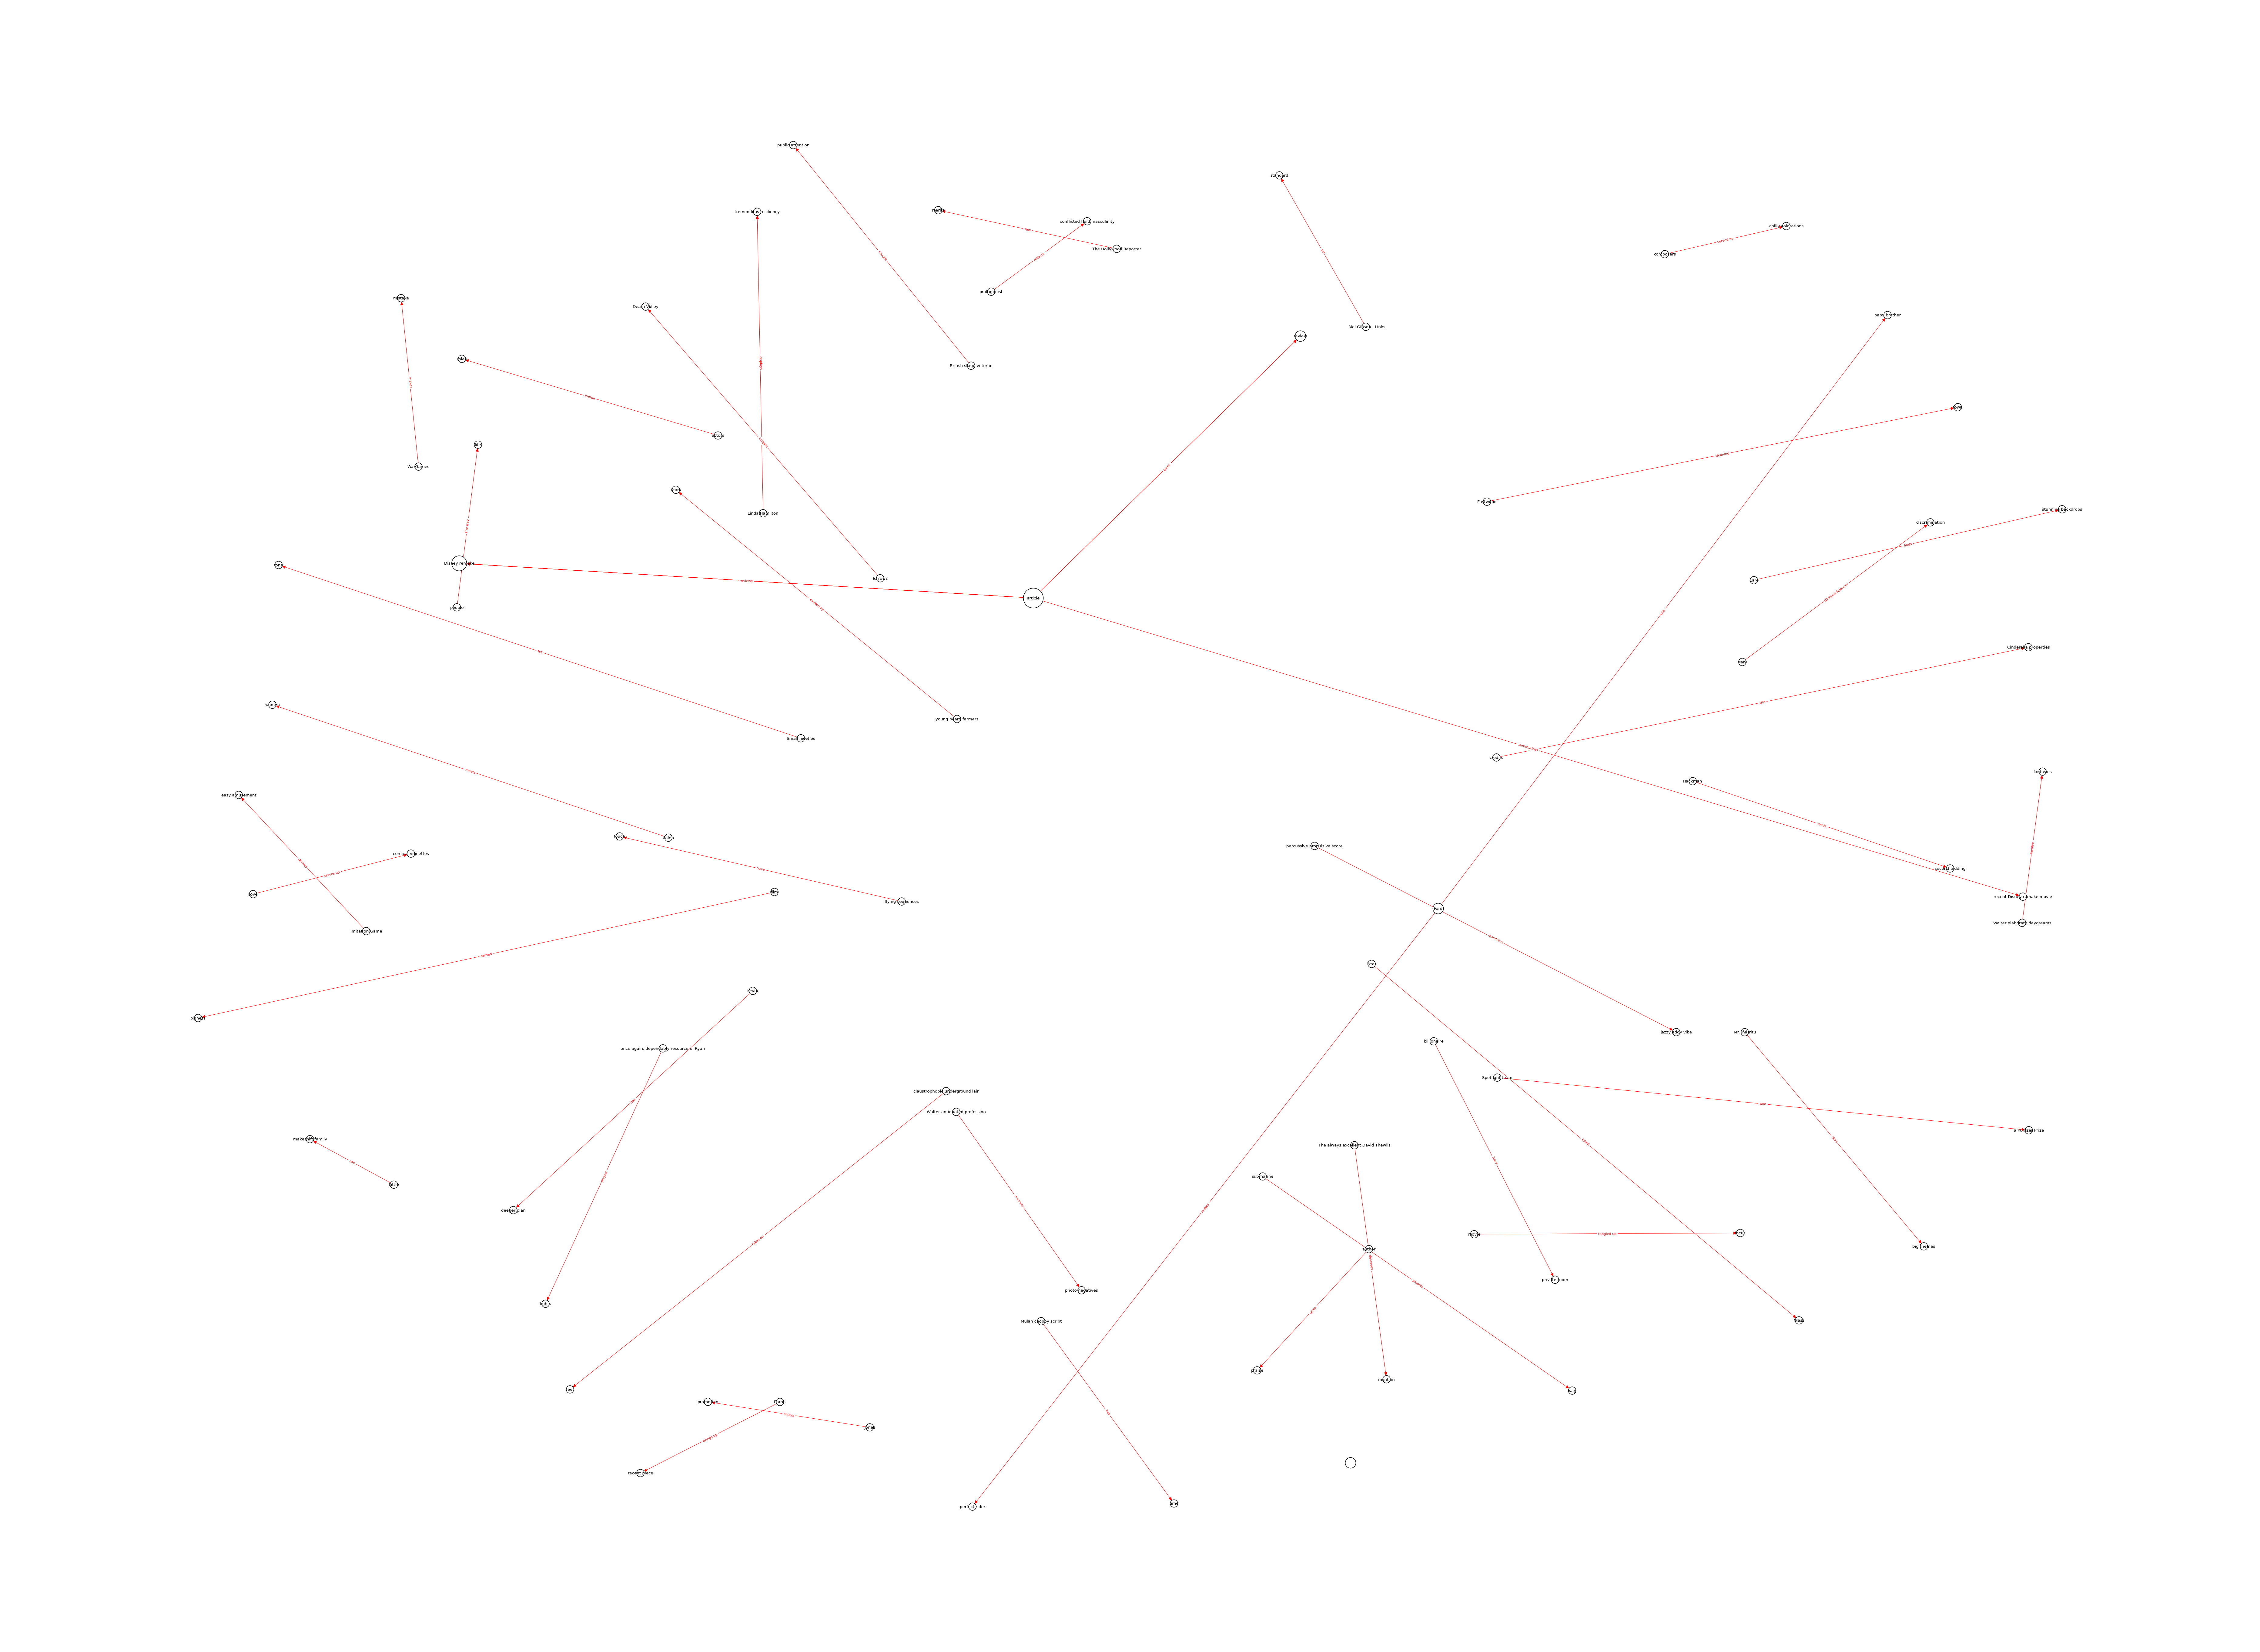

In [29]:
draw_kg(pairs)

In [32]:
# If a drawn graph becomes unintelligible we can increase the figure size or filter/query.
def filter_graph(pairs, node):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    edges = nx.dfs_successors(k_graph, node)
    nodes = []
    for k, v in edges.items():
        nodes.extend([k])
        nodes.extend(v)
    subgraph = k_graph.subgraph(nodes)
    layout = (nx.random_layout(k_graph))
    nx.draw_networkx(
        subgraph,
        node_size=1000,
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white'
        )
    labels = dict(zip((list(zip(pairs.subject, pairs.object))),
                    pairs['relation'].tolist()))
    edges= tuple(subgraph.out_edges(data=False))
    sublabels ={k: labels[k] for k in edges}
    nx.draw_networkx_edge_labels(subgraph, pos=layout, edge_labels=sublabels,
                                font_color='red')
    plt.axis('off')
    plt.show()

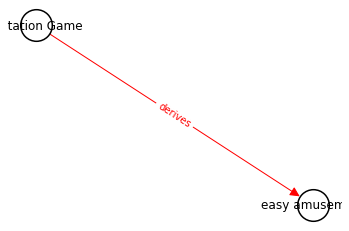

In [31]:
filter_graph(pairs, 'Imitation Game')

In [33]:
nlp = spacy_universal_sentence_encoder.load_model('xx_use_lg')
nlp_pos = spacy.load("en_core_web_lg")

# Create a list of stop words from nltk
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

Downloaded https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3, Total size: 334.32MB

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [34]:
from spacy import displacy

docs=[]
for text in data['processed_text']:
    doc = nlp(text)
    docs.append(doc)

for text in data['processed_text']:
    doc = nlp_pos(text)
    # Analyze syntax
    print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
    print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

    # Find named entities, phrases and concepts
    for entity in doc.ents:
        print(entity.text, entity.label_)

# extract subject
    source = [chunk.text for chunk in doc.noun_chunks]

# extract object
    target = [entity.text for entity in doc.ents]

# extract verb
    edge = [token.lemma_ for token in doc if token.pos_ == "VERB"]
    displacy.render(doc, style = "ent",jupyter = True)

Noun phrases: ['the spring', 'the filmmaker stanley kubrick', 'nasa', 'the mariner space probe', 'mars', 'we', 'intelligence', 'even believable evidence', 'pond scum', 'the universe', 'lack', 'effort', 'a new spacecraft tess', 'habitable nearby planetsjust', 'space', 'the solar system', 'radio signals', 'another robot', 'its way', 'the heart', 'mars', 'we', 'we', 'the story', 'africa', 'a bunch', 'bedraggled primates', 'the battle', 'the survival', 'a strange black monolith', 'the thunder', 'also sprach zarathustra', 'those apemen', 'a bone', 'it', 'a club', 'the animals', 'him', 'kubrick', 'his movie', 'human evolution', 'another monolith', 'the moon', 'orbit', 'jupiter', 'an astronaut', 'dave bowman', 'it', 'a neurotic computer', 'the hal', 'his shipmates', 'the finale bowman', 'a star gate', 'a trip', 'space', 'time', 'death', 'a glowing star child', 'a fetus', 'the earth', 'another poignant time', 'history', 'it', 'space', 'the cosmos', 'we', 'the moon', 'the script', 'future', 'th

Noun phrases: ['i', 'this review', 'a word processor', 'a computer', 'the type', 'the sun times', 'i', 'an error', 'the computer', 'me', 'i', 'it', 'this review', 'a width', 'characters', 'it', 'things', 'i', 'it', 'the width', 'characters computers', 'what', 'they', 'they', 'their programs', 'illogical conclusions example', 'i', 'the computer', 'my review', 'a width', 'characters', 'it', 'it', 'me', 'my way', 'i', 'the s', 'these self', 'sublimely confident thinking machines', 'us', 'the face', 'the planet', 'the message', 'wargames', 'a scary and intelligent new thriller', 'the best films', 'the movie', 'starsmatthew', 'broderick', 'the kid', 'max dugan returns', 'a bright high school senior', 'who', 'a lot', 'time', 'his bedroom', 'his home computer', 'he', 'telephone', 'the computer', 'his school', 'grades', 'he', 'bigger game', 'he', 'a toy company', 'a new computer game', 'he', 'his computer', 'a random search', 'telephone numbers', 'the company s area code', 'a number', 'a compu

Noun phrases: ['the matrix', 'keanu reeves', 'laurence fishburne carrie', 'anne moss', 'andy', 'extremely violent extremely preposterous extremely entertaining the matrix', 'two extremely difficult tasks', 'a vast exciting virtual reality movie', 'a defibrillator', 'keanu reeves', 'big screen career', 'the pantheon', 'movie iconography', 'the past years', 'high noon showdowns', 'bad kung fu', 'the writing', 'team', 'the wachowski brothers', 'andy', 'a fantastic hodgepodge symmetry', 'hacker noir comedy', 'mindless action', 'thomas anderson reeves', 'a talented computer programmer', 'a monolithic corporation', 'the day', 'night', 'he', 'an unscrupulous hacker', 'neo', 'his work', 'him', 'the attention', 'morpheus', 'a mysterious stranger', 'who', 'morpheus', 'him', 'lewis carroll', 'alice', 'talk', 'other worlds', 'realities', 'he', 'neo', 'two pills', 'a blue one', 'things', 'they', 'a red one', 'the veil', 'his eyes', 'him', 'the rabbit hole', 'a movie', 'the plot', 'he', 't neo', 'th

Noun phrases: ['i robot', 'place', 'chicago', 'a city', 'spectacular new skyscrapers', 'the skyline', 'landmarks', 'the sears', 'not the trump tower', 'the buildings', 'u s robotics', 'the floor', 'its atrium lobby', 'the dead body', 'its chief robot designer', 'a suicide det del spooner', 'the case', 'spooner', 'a chicago police department detective', 'who', 't', 'it', 'suicide', 'he', 'a deep seated mistrust', 'robots', 'the famous three laws', 'robotics', 'a robot', 'a human', 'the dead man', 'dr alfred lanning james cromwell', 'who', 'we', 'the three laws', 'every schoolchild', 'the laws', 'the good doctor isaac asimov', 'a conversation', 'he', 'dec', 'withjohn', 'campbell', 'the legendary editor', 'astounding science fiction', 'it', 'no one', 'the film', 'the film', 'the book', 'isaac asimov', 'it', 'the filmmakers', 'asimov', 'the movie', 'spooner', 'those movie cops', 'who', 'the powerful races', 'town', 'his badge', 'his captain', 'the crime', 'incredible physical adventures', 

Noun phrases: ['a recent run ofoverly hyped butultimatelydisappointingsci fi efforts fans', 'the genre', 'something', 'non genre filmgoers', 'the first time', 'a long time', 'we', 'an artificial intelligence film', 'well intelligence ex machina novelist', 'screenwriteralex garlandsdirectorial debut', 'the well worn sci fi territory', 'technophobia god complexes', 'lethal robots', 'it', 'an intelligence', 'sophistication', 'either the viewer', 'the capacity', 'the genre', 'the film', 'a nice young coder', 'caleb', 'domhnall gleeson', 'a mysterious trip', 'a week', 'the opulent home', 'a compound', 'nathan oscar isaac', 'his boss', 'ceo', 'fictional internet giant blue book', 'his visit', 'caleb', 'nathans assistant', 'lover', 'his invention', 'a robot', 'ava alicia', 'vikander', 'ava', 'the robot', 'a cgi confection', 'human face hands', 'feet', 'sinewy mesh translucent limbs', 'a see', 'torso', 'blinking lights', 'whirring gears', 'nathan', 'caleb', 'engaging ava', 'the turing test', '

Noun phrases: ['jonze s her plays', 'a kind', 'miracle', 'its opening shots', 'an unabashed declaration', 'eternal love', 'an unseen soul mate', 'the movie', 'the viewer', 'what', 'an ordinary guy theodore', 'his e mail', 'the ride home', 'work', 'us', 'these daysdirector jonze', 'who', 'the movie s script', 'a beguiling cinematic world', 'the viewer', 'theodore', 'smart phone', 'its earpiece work', 'ours', 'it', 'her', 'something', 'a science fiction film', 'the not too distant but distinctly fantastic future', 'the futuristic premise', 'the stage', 'an unusual love story', 'theo', 'the breakup', 'his marriage', 'i', 'you', 'a friend', 'him', 'a voice mail message', 'you', 'the old fun', 'you', 'love', 'the artificially intelligent operating system', 'his computer', 'the movie', 'this product', 'remarkable quantity', 'theo s interaction', 'he', 'a female voice', 'the female voice', 'herself', 'the name samantha', 'samantha', 'theo s files', 'him', 'something', 'a human consciousness',

Noun phrases: ['oct', 'a newsci fifranchise', 'the u s theatrical debut', 'the terminator', 'the hollywood reporter', 'the merits', 'the film', 'a sequel', 'the original review', 'no doubt', 'it', 'arnold schwarzenegger', 'playthe terminator', 'fiadventure', 'fromhemdale', 'the beefyconanstar', 'his first villainous role dishes', 'destruction', 'a fiendish relish', 'box office competition', 'the havoc', 'a genuine steel metal trap', 'a movie', 'the best picture', 'its kind sincethe road warrior schwarzenegger', 'an emotionless cyborg', 'the future', 'a young woman', 'linda hamilton', 'whose unborn child', 'apostapocalypticsaviour', 'him', 'the girl', 'the terminator', 'the outcome', 'their struggle', 'eerieflashforwardsto', 'the skull', 'streets', 'stcentury los angeles', 'us', 'the future', 'the world', 'a remarkably spare script', 'james cameron', 'gale annehurdgives', 'new dimension', 'this age old morality play', 'plenty', 'pointed comment', 'our presentovermechanizationinto', 'its

Noun phrases: ['title disney s new mulan', 'a dull reflection', 'vanity', 'disneys new mulan', 'a dull reflection', 'the original top words', 'mulan disney action remake lifeless summary', 'this article', 'the recent disney remake movie mulan', 'the author', 'the movie', 'a lifeless remake', 'the magic', 'creativity', 'the original disney movie', 'the ancient year', 'disney', 'something', 'an action movie', 'big fight scenes', 'little boys', 'who', 'another beauty', 'the beast', 'little mermaid', 'such balking', 'boys', 'it', 'it', 'mulan', 'the chinese legend', 'warrior woman hua mulan', 'who', 'the emperor s army', 'her father', 'a man', 'a half hearted project', 'diversity', 'more global shape', 'its princess canon', 'it', 'the time', 'a big deal', 'the film', 'barry cook', 'tony bancroft', 'that bigness', 'enough places', 'the powerhouse ballad reflection', 'lea salonga', 'the film', 'christina aguilera', 'her most enduring songs', 'mountain battle scene', 'ever more confident comp

Noun phrases: ['title cinderella', 'straight faced sentimentality publication source venue', 'the guardian mar', 'pm', 'url https', 'www theguardian com film mar cinderella', 'straight faced sentimentality', 'kenneth branagh top words', 'disney cinderella ravishing fairytale old fashioned summary', 'this article', 'a review', 'disney s recent cinderella remake', 'the author', 'the movie', 'the old fashioned world', 'cinderella', 'this article', 'the first document', 'a review', 'disney remake', 'a classic', 'a fairytale element', 'kenneth branagh', 'career', 'the question', 'he', 'the ball', 'all his movies', 'branagh s finest fantasy flicks', 'mary shelley s frankenstein', 'charles perrault s fabled heroines', 'the marvellously ken russell', 'the magic flute', 'riches', 'the belle', 'any box office ball', 'the hitchcock pastiche', 'a copper bottomed catastrophe', 'a stateside hit', 'an th hour sprinkling', 'fairy dust', 'the form', 'reprocessed black and white flashbacks', 'it', 'paup

Noun phrases: ['title aladdin review', 'what', 'you', 'publication source venue', 'the new york times', 'https www nytimes com movies', 'aladdin review html auth login', 'top words', 'disney aladdin exploitation weird stereotypes summary', 'this article', 'a review', 'disney s recent aladdin remake', 'the author', 'the movie', 'the main focus', 'profits', 'its various brands', 'nothing', 'the movie', 'the racial and cultural stereotypes', 'various problems', 'the cartoon feature', 'robin williams', 'a garrulous blue genie', 'the best movie', 'disney s second golden age', 'animation', 'the others', 'it', 'durable charms', 'memorable songs', 'the new live action', 'a blue', 'smith', 'the lamp', 'the worst product', 'the current era', 'legacy intellectual property exploitation', 'it', 'the others', 'it', 'a simple question', 'the answer spoiler alert money', 'you', 'i', 'it', 'disney s drive', 'every last dollar', 'its various brands', 'you', 'the animal sidekicks', 'i', 'the movie', 'its

Noun phrases: [' title review beauty', 'the beast', 'joy and enchantment publication source venue', 'the new york times mar url https www nytimes com movies', 'beauty', 'the beast review', 'html', 'top words', 'classicism disney familiar enchanted vivid summary', 'this article', 'the disney remake', 'beauty', 'the beast', 'the author', 'the movie', 'it', 'the enchantment', 'classicism', 'this article', 'it', 'yet another disney remake', 'a lyric', 'the songs', 'beauty', 'the beast', 'something', 'the familiar elements', 'place', 'course', 'it', 'beauty', 'the beast', 'goodness sake', 'a tale', 'time', 'a song', 'rhyme', 'flights', 'nostalgia', 'well visual evocations', 'the predigital glory', 'busby berkeley ray harryhausen', 'other masters', 'fantastical craft', 'this live action digital hybrid', 'bill condon', 'emma watson', 'dan stevens', 'the title roles', 'a flesh', 'blood', 'fur', 'horns', 'revival', 'the year old cartoon', 'a dutiful trip', 'the pop culture fairy tale', 'its cla

Noun phrases: [' title film review tim burton s dumbo publication source venue variety mar', 'url https variety com film', 'top words', 'disney parable emotional cracked wonderstruck summary', 'this article', 'the disney remake', 'dumbo', 'the author comments', 'the original dumbo', 'viewers', 'awe', 'feelings', 'joy', 'the remake', 'a new twist', 'the story', 'an animal', 'a showman', 'the key image', 'walt disney s dumbo', 'something', 'a fairy tale', 'daydream dumbo', 'the baby elephant', 'long lashed goo goo eyes', 'a cuddly grin', 'ears', 'wings', 'those ears', 'a circus big top', 'the crowds', 'a freedom', 'it', 'it', 'the purest images', 'movies', 'dumbo', 'disney s fourth animated feature', 'pinocchio', 'fantasia', 'dumbo', 'himself', 'it', 'a beautiful oddball a solid colored piece', 'stylized pop americana', 'times', 'almost a silent movie', 'sound effects', 'the more remarkable things', 'it', 'that dumbo', 'his mother', 'a primal twist', 't', 'his ability', 'the last six min

Noun phrases: [' title', 'the jungle book', 'spectacular revival', 'disney s family favorite publication source venue', 'the guardian', 'apr edt url https www theguardian com film', 'the jungle book', 'top words', 'disney mowgli', 'spectacular witty spirit summary', 'this article', 'the disney remake', 'the jungle book', 'the author', 'this new movie', 'the spirit', 'the original disney movie', 'the original masterpiece', 'the author', 'praise', 'the actors', 'digital rendering', 'ease', 'story', 'what', 'earth', 'the point', 'walt disney', 'great and possibly greatest masterpiece', 'kipling s tales', 'the man cub mowgli', 'wolves', 'the indian jungle', 'the last film', 'disney s personal touch', 'a remake', 'old fashioned animation', 'the live action uncanny valley', 'hyperreal cgi', 'heretically', 'the songs', 'the original s final unforgettably exotic glimpse', 'a real life human girl', 'no point', 'a terrifically enjoyable piece', 'old fashioned storytelling', 'a beautiful looking 

Noun phrases: ['what', 'a nice girl', 'this hole publication source venue', 'www nytimes com movies', 'alice', 'top words', 'disney alice grim dark nightmarish summary', 'this article', 'the disney remake', 'alice', 'wonderland', 'the author', 'burton', 'this movie', 'a dark and grim story', 'the personality', 'the main character', 'alice', 'the dark', 'you', 'alice', 'wonderland', 'tim burton', 'busy garish and periodically amusing repo', 'alice', 'wonderland', 'it', 'a long fall', 'long haul', 'the burtonian', 'the pinch', 'cruelty', 'the mordant wit', 'the red queen helena bonham carter', 'the porker', 'her feet', 'a squeal', 'i', 'a warm pig belly', 'my aching feet', 'the queen', 'alice', 'mia wasikowska', 'alice', 'she', 'her pulse', 'ground', 'she', 'the rabbit hole', 'mr burton s imagination', 'mr burton', 'his best work', 'contemporary stories', 'it', 'he', 'his sights', 'another th century tale', 'all those throats', 'his adaptation', 'sweeney todd', 'he', 'he', 'a few heads',

Noun phrases: ['title air force', 'one review authors', 'maslin source date', 'new york', 'th url air force', 'one nytimes com', 'harrison ford plane president', 'glenn', 'close first lady', 'a f o monograms', 'presidential hand towels', 'the little things', 'wolfgang petersen s fast paced red blooded action movie air force', 'one small niceties', 'the presidential plane', 'the tone', 'a larger amenity', 'the brave tough decent commander', 'chief', 'warmly electable fashion', 'harrison ford president james marshall', 'pure paragon', 'a statesman', 'strong backbone', 'who', 'his wife', 'no one', 'ford waves', 'admirers', 'the president s airplane', 'he', 'no trouble', 'the star', 'the inspiration', 'the man', 'himself', 'who', 'the summer s most enjoyable special effect', 'voyeurism', 'he', 'air force', 'what', 'routine excitement', 'crazed terrorists midair dogfights desperate struggles', 'an airplane s open door', 'dialogue', 'manful military authority', 's', 'any more time', 'the nim

Noun phrases: ['title', 'desson howe source date', 'washington post', 'danger', 'the hunt', 'cia washington', 'america', 'a recurring dream', 'a movie', 'the third film', 'novelist tom clancy s jack ryan series', 'the hunt', 'red october', 'patriot games', 'it', 'the usual round', 'situation room anxiety', 'the cia shady maneuverings', 'washington power corridors', 'secret battles', 'foreign adversaries', 'once again dependably resourceful ryan', 'a second time', 'harrison ford fights', 'truth justice', 'the american way', 'this story cia analyst agent ford', 'a desk job', 'his old lion', 'a mentor james earl jones', 'admiral james greer', 'a worthy successor', 'jones', 'a va hospital ford', 'the cia s acting deputy director', 'himself', 'stern congresswoman hope lange', 'the company s request', 'funds', 'the colombian government', 'the drug cartels', 'troops', 'ford', 'someone', 'his side', 'the taxpayers', 'lucre', 'covert military operations', 'he', 'heroes', 'so dumb ford', 'himsel

Noun phrases: ['title crimson tide review authors', 'desson howe source date washington post', 'th url crimson tide washingtonpost com keywords denzel washington gene hackman nuclear bomb code crew members', 'it', 'submarines boys', 'boys', 'the cold war', 'damned crimson tide', 'gene hackman', 'denzel washington', 'hands', 'nuclear bombing codes', 'crew members', 'themselves', 'clocks', 'the world s final minutes', 'the scenario', 'a wimpy ending', 'boot', 'it', 'a rebel russian leader', 'a missile base', 'the united states', 'japan', 'the american government', 'a nuclear submarine', 'major alert', 'monastic choral voices', 'them', 'the soundtrack war mongering skipper hackman', 'his sensitive but strong lieutenant commander washington board', 'the uss alabama', 'post reds', 'october', 'the submarine', 'its way', 'the possible outbreak', 'world war iii hackman', 'washington duke', 'captain bligh', 'their conflict', 'the best element', 'the movie', 'washington', 'the pulse', 'the crew'

Noun phrases: ['title hunt', 'red october review authors', 'url reviews film connery', 'captain', 'a renegade soviet sub', 'the new york times nytimes com', 'sean connery', 'soviet submarine red october united states', 'sonar captain alec baldwin hunt', 'tom clancy', 'the hunt', 'red october', 'marko', 'ramius sean connery', 'the captain', 'a new atomic powered top', 'the line soviet submarine', 'the red october', 'a fellow officer', 'ship', 'the captain', 'he', 'armageddon', 'it', 'he', 'his wife', 'good grief', 'a maniac', 'charge', 'a ship', 'enough missiles', 'virtually every major city', 'the united states', 'what', 'the red october', 'a new hydropropulsion system', 'a technological breakthrough', 'it', 'detection', 'even the most sophisticated sonar equipment', 'only a hotshot sonar engineer', 'the difference', 'the sounds', 'the red october', 'the mating', 'whales', 'it', 'the lunatic captain', 'coney island', 'everything', 'the ferris wheel', 'denver', 'no hope', 'mankind', 'th

Noun phrases: ['title', 'the line', 'fire review authors', 'washington post', 'th url', 'the line', 'fire washingtonpost com keywords', 'jfk assassination', 'california', 'the town', 'punks varmints', 'career criminals', 'recent years', 'that head', 'the leathery skin', 'the skull', 'the furrows', 'his face', 'death valley', 'this creeping hoary condition', 'things', 'even the most throwaway roles', 'poignance', 'he', 'opponents', 'he', 'time', 'itself', 'the horrible softness', 'age', 'he', 'it', 'us', 'old farts', 'the line', 'fire', 'him', 'presidential limousines', 'a brilliant movie', 'thanks', 'eastwood', 'it', 'frank horrigan', 'a veteran secret service agent', 'need', 'redemption', 'he', 'command', 'the ravages', 'time', 'the insults', 'young lion colleagues', 'he', 'assassin john malkovich', 'it', 'him', 'the point', 'this cat and mouse movie', 'eastwood', 'a bullet', 'the president', 'he', 'his life', 'the line', 'it', 'the deepest thematic concern', 'you', 'screen', 'it', 'w

Noun phrases: ['title patriot games review authors', 'howe source date', 'th url patriot games', 'r washingtonpost com', 'harrison ford tom clancy jack ryan', 'present danger', 'the hunt', 'america', 'irish terrorist london chesapeake bay bridge cia spymaster', 'the creative recession', 'the movies', 'you', 'patriot games', 'summer movie guidelines', 'it', 'it', 'sight', 'its mall movie mandate', 'american hearth', 'home', 'invincible boy toy bogymen', 'this very loose adaptation', 'the tom clancy novel', 'the author', 'inactive cia analyst harrison ford wife anne archer', 'daughter thora birch', 'themselves', 'a vengeful irish terrorist', 'vacation', 'his family', 'london ford', 'an assassination attempt', 'royal family member james fox', 'the melee ford', 'the baby brother', 'mega assassin sean bean', 'ford', 'archer', 'their backs', 'a man', 'no regard', 'human life', 'the movie', 'the globe', 'an extended set', 'climaxes', 'a story', 'a bomb explosion', 'london deadly traffic troub

Noun phrases: ['title', 'the fugitive review authors', 'washington post', 'august th url', 'the fugitive pg', 'washingtonpost com', 'harrison ford tommy lee jones doctor covict murder chicago surgeon execution', 'the violent death', 'wife', 'the mysterious one armed assailant', 'who', 'her', 'kimble', 'wrongful sentencing', 'death', 'the murder', 'these elements', 'the tv series', 'the fugitive viewers', 'four seasons', 'who', 'the train', 'him', 'his execution', 'the killer', 'a step', 'his relentless pursuer lt gerard', 'the climactic final episode', 'august', 'the odyssey', 'a resolution', 'the roof', 'a high building', 'a three way confrontation', 'kimble david janssen mystery man fred johnson', 'lt gerard', 'the show', 'the highest number', 'viewers', 'an episode', 'television history', 'who', 'j', 'r revelation', 'the first episode', 'a movie version', 'the fugitive', 'harrison ford', 'tommy lee jones', 'a new run', 'it', 'a great one', 'the times', 'us', 'the late janssen', 'the

Noun phrases: ['a city', 'light', 'a city', 'lovers', 'the perfect setting', 'jean pierre jeunets', 'wonderfully charmingamlie', 'plenty', 'character', 'heart', 'this classic french hit', 'the dictionary definition', 'feel good amlie', 'no ordinary woman', 'the beautifully fresh faced audrey tautou', 'she', 'a young woman', 'who', 'the lives', 'the people', 'her', 'their sad little problems', 'she', 'a strange photo album', 'nino mathieu kassovitz', 'she', 'she', 'love', 'problems', 'her own some plot details', 'amlie', 'other children', 'her father', 'a man', 'garden gnomes', 'her', 'a weak heart', 'a suicidal person', 'a building', 'amlies luckless mother', 'her flat amlie', 'life', 'a distance', 'the death', 'princes', 'diana', 'her', 'a hidden old rusty box', 'a young boy', 'his treasures', 'the boy', 'a grown man', 'she', 'the box', 'an overjoyed owner', 'amlie', 'secret', 'her lifes', 'she', 'people', 'herself', 'us', 'she', 'the most brilliant ways', 'their happiness', 'she', 'm

Noun phrases: ['i', 'one aspect', 'myself', 'the backdrop', 'each country', 'a place', 'that one thing', 'elizabeth gilbert', 'her popular memoireat', 'pray love', 'i', 'the art', 'pleasure', 'italy', 'the art', 'devotion', 'india', 'indonesia', 'the art', 'the premise', 'the problem', 'witheat', 'love', 'comma free screen incarnation', 'the world', 'a kind', 'sprawling full service spa treatment', 'the soul', 'the senses', 'the spirit', 'the heart', 'nice therapy', 'you', 'it', 'thougheat', 'lovenever', 'the sour whiff', 'unexamined first world privilege', 'its heroine', 'herself', 'different cultures', 'them', 'her', 'a sun', 'julia roberts liz', 'this adventure', 'new experiences', 'the vise grip', 'she', 'every aspect', 'her life', 'the little tension', 'her journey', 'the push', 'her itinerary', 'the book pitch', 'money', 'it', 'her desire', 'the essence', 'a true vacation', 'she', 'it', 'liz', 'a plane events', 'her life', 'all the packing', 'her feeling', 'a domestic situation',

Noun phrases: ['a stroll', 'paris', 'a warm spring evening', 'something', 'owen wilsons character', 'himself', 'paris', 'woody allens companion piece', 'cairo', 'a fanciful time machine', 'him', 'the artistic paris', 'his and many other peoples', 'a sure fire source', 'gentle amusement', 'allens core audience', 'no knowledge', 'the paris', 'the fitzgeralds', 'hemingway gertrude stein', 'this love letter', 'the city', 'average business', 'the writer director', 'the u', 's', 'its', 'expectations', 'certain foreign territories', 'allen', 'photogenic foreign locales', 'london', 'match point barcelona', 'vicki cristina barcelona', 'the director', 'the possibilities', 'a new environment', 'fact', 'allen', 'paris', 'a writer', 'actor', 'what', 'new pussycat', 'one section', 'everyone', 'i', 'you', 'the first time', 'he', 'the city', 'the royal treatment', 'its mostly a touristic view', 'the city', 'the voluptuously', 'opening montage', 'famous sites', 'the leading characters', 'americans', 'v

Noun phrases: ['good movie', 'rajasthan', 'india india', 'you', 'a wave', 'you', 'you', 'you', 'it', 'you', 'the words', 'the best exotic marigold hotel narrator evelyn greenslade', 'the luminous judi dench', 'she', 'seven british retirees', 'who', 'jaipur rajasthan india', 'a restored luxury hotel', 'their expectations', 'the hotel', 'a shambles', 'its future', 'doubt', 'the characters', 'who', 'the challenges', 'them', 'a new unexpected life', 'what', 'you', 'this country', 'what', 'you', 'i', 'unhappy jean ainslie penelope wilton', 'who', 'india', 'retreats', 'seething negativity', 'i', 'this reaction', 'people', 'india', 'i', 'other experienced india travellers', 'too the light', 'the colours', 'the people', 'life', 'a gift', 'a privilege', 'not a right', 'all life', 'answers', 'tom wilkinson', 'i', 'the movie', 'the expected reasons', 'i', 'the portrayal', 'india', 'i', 'i', 'the direction', 'john madden', 'who', 'shakespeare', 'love', 'i', 'i', 'dev patel slumdog millionaire', 'a

Noun phrases: ['the sublime director star ben stiller s retelling', 'the secret life', 'walter mitty', 'an earnest but not entirely effective fable', 'the doldrums', 'daily life', 'change', 'the short story', 'james thurber', 'the screen', 'danny kaye stiller s adaptation', 'the title character', 'a nice but forgettable man', 'a humdrum routine life', 'walter s elaborate daydreams', 'fantasies', 'himself', 'an action hero', 'a romantic explorer', 'reality', 'he', 'a meek man', 'a life', 'a relentlessly helpful eharmony call center rep', 'patton oswalt', 'him', 'his online profile', 'he', 'some views', 'walter', 'the attention', 'cheryl kristen wiig', 'a co worker', 'who', 'eharmony walter s antiquated profession', 'photo negatives', 'life magazine', 'the digital age', 'the venerable publication years', 'the st century mind', 'you', 'whose new owners', 'a bearded adam scott', 'his likewise bearded minions', 'the print edition', 'the entire operation', 'online layoffs', 'imminent walter'

Noun phrases: ['the bucket list', 'a movie', 'about two old codgers', 'who', 'nothing', 'people', 'cancer', 'nothing', 'cancer', 'adventures', 'nothing', 'i', 'hospitals', 'the dvd', 'your patients', 'an outbreak', 'bedpans', 'tv screens', 'the film', 'yet another voiceover narration', 'morgan freeman', 'the saintly virtues', 'a white person', 'who', 'our reverence', 'his voice', 'a sort', 'wonderment', 'he', 'the man s greatness', 'it', 'a note', 'the shawshank redemption', 'million dollar baby', 'he', 'a character', 'jack nicholson', 'whom', 'lovability', 'a strong suit', 'nicholson', 'edward', 'an enormously rich man', 'who', 'cancer', 'a year', 'a room', 'carter freeman', 'about the same age same prognosis', 'a billionaire', 'a private room', 'edward', 'the hospital', 'he', 'a policy', 'all patients', 'it', 'he', 'countless details', 'the movie', 'edward', 'hospitals', 'lotsa profits', 'private rooms concierge service', 'the fact', 'edward', 'carter', 'roommates', 'their meet', 'th

Noun phrases: ['frisky and frivolous woody allens', 'rome', 'love', 'four comical vignettes', 'the latest stop', 'the directors', 'breezy tour', 'romantic euro locales', 'rome', 'if somewhat superficial backdrop', 'various broad caricatures', 'half', 'them', 'the rest italian', 'semi surreal complications', 'their private lives', 'the eternal city', 'none', 'too strenuous arthouse excursion', 'a throwback', 'allens short story anthologies', 'the added pleasure', 'a game cast play', 'pic', 'italy', 'it', 'allen', 'new york', 'his sunset years', 'the worlds', 'most beautiful cities', 'the truth', 'the consistently prolific septuagenarian', 'a wider audience', 'his recent visits', 'london match point', 'barcelona vicky cristina barcelona', 'paris midnight', 'paris', 'allens top grossing pic', 'the standard complaint', 'allen', 'movies', 'the very pseudo intellectuals', 'his characters', 'the multihyphenates lifelong preoccupation', 'death', 'he', 'the end', 'allen', 'that tall dark strang

Noun phrases: [' hidden figures', 'us', 'racial segregation', 'workplace sexism', 'widely accepted facts', 'life', 'the word computer', 'a person', 'not a machine', 'a gigantic ibm mainframe', 'the movie', 'a room', 'the phone', 'your pocket', 'the most important computers', 'three african american women', 'who', 'nasa headquarters', 'hampton va', 'data entry jobs', 'recognition', 'promotion', 'they', 'crucial roles', 'the american space program', 'many movies', 'the overcoming', 'racism', 'it', 'belated acknowledgment', 'bravery', 'talent', 'an overdue reckoning', 'the sins', 'the past', 'most movies', 'real world breakthroughs hidden figures', 'established conventions', 'the story', 'most viewers', 'the manner', 'it', 'the youngest start', 'the three principals', 'whose struggles', 'nasa', 'place', 'the agency', 'an astronaut', 'orbit', 'katherine goble', 'the central hidden figure', 'a mathematical prodigy', 'perfect nerd charisma', 'taraji', 'henson katherine', 'the computing room'

Noun phrases: ['the imitation game', 'a highly conventional movie', 'a profoundly unusual man', 'a bad thing', 'tragically shortened life', 'he', 'he', 'a complex and fascinating story', 'ideas', 'present day implications', 'it', 'the streamlined structure', 'accessible presentation', 'modern prestige cinema', 'the science', 'the emotions', 'the truth', 'history', 'room', 'tidy and engrossing drama', 'an alan turing biopic', 'all a very welcome thing', 'his decisive contribution', 'the breaking', 'the nazi enigma code', 'the allied forces', 'an intelligence advantage', 'germany', 'the extent', 'his wartime role', 'many years', 'the secret', 'his homosexuality', 'he', 'indecency charges', 'a cold war climate', 'homophobia', 'political paranoia', 'the pseudoscientific cruelty', 'the british judicial system', 'whom', 'the film', 'the autism spectrum', 'he', 'he', 'patterns', 'others', 'himself', 'the desert', 'the literal jokes', 'his head sarcasm', 'his colleagues', 'we', 'some lunch tur

Noun phrases: ['one point', 'argo', 'a smart jittery thriller', 'a freakish and little known chapter', 'the iranian hostage crisis', 'a hollywood producer', 'history', 'farce', 'tragedy', 'he', 'someone', 'it', 'a professional dissembler', 'he', 'the revolutionary shock troops', 'who', 'the united states embassy', 'nov', 'the crisis', 'political theater', 'the entire world tune', 'tomorrow', 'america', 'trial', 'the special guest star', 'the ayatollah khomeini', 'the producer', 'historical events', 'don t', 'it', 'you', 'lights camera action', 'history', 'farce', 'what', 'j', 'a central intelligence agency officer', 'he', 'six state department employees', 'tehran', 'revolutionary forces', 'the embassy', 'hostages', 'the men', 'women', 'who', 'days', 'five americans', 'they', 'their way', 'safety', 'the canadian ambassador s house', 'a sixth escapee', 'i', 'a the state department', 'the president', 'a way', 'them', 'mr mendez', 'a wizard', 'disguise', 'the cover story', 'the six escapee

Noun phrases: ['oliver stone s snowden', 'a quiet crisply drawn portrait', 'the world s most celebrated whistle blower', 'a curious subgenre', 'movies', 'very recent historical events', 'the usual pattern', 'it', 'a fictional making', 'feature', 'citizenfour laura poitras s oscar winning documentary', 'the former national security agency contractor', 'edward', 'j snowden', 'the context', 'this director s career snowden', 'a return', 'form', 'something', 'a departure mr stone circles', 'the grand questions', 'power war', 'secrecy', 'his most ambitious work', 'a hero', 'who', 'a familiar oliver stone mold', 'edward joseph gordon levitt', 'a vocal imitation', 'a disillusioned idealist', 'a serious young man', 'whose experiences', 'him', 'accepted truths', 'the wisdom', 'authority', 'he', 'something', 'jim garrison', 'j', 'july', 'chris taylor', 'bud fox', 'the characters', 'charlie sheen', 'platoon', 'wall street', 'those young men', 'a hurry', 'edward', 'the sway', 'two antithetical fath

Noun phrases: ['the movie', 'the revenant', 'a novel', 'revenge', 'a historical adventure', 'michael punke', 'the real hugh glass', 'glass', 'the rocky mountain fur company', 'an expedition', 'the upper missouri river', 'him', 'arikara indians', 'the group', 'he', 'a grizzly bear', 'her cubs', 'the bear', 'glass', 'some help', 'strangers', 'the indestructible romance', 'the american west', 'him', 'a mountain man legend', 'the inspiration', 'various accounts', 'a book length poem', 'a film man', 'the wilderness', 'who', 'exactly the savage', 'an issue', 'a sign', 'french spells', 'one scene', 'everyone', 'mr i rritu', 'big themes', 'he', 'subtlety', 'a shocker', 'an image', 'instance', 'amores perros', 'his feature debut', 'his talent', 'the indelible cinematic shot', 'the one', 'you', 'you', 'his penchant', 'overstatement', 'those multi stranded stories', 'he', 'babel etc amores perros', 'a murder', 'the vision', 'human blood', 'a hot griddle', 'a big moment', 'an illustration', 'mr i 

Noun phrases: ['a brutal kinetic', 'a scene', 'muddy hand', 'combat', 'the opening', 'private ryan lincoln', 'what', 'the familiar pageantry', 'speechifying', 'costume drama', 'a flock', 'first rate character actors parades', 'the heavy woolen plumage', 'the past', 'the smaller plainer america', 'the mid th century', 'the brownish chiaroscuro', 'cinematography', 'the mud brick', 'wood', 'rick carter s production design', 'enough important facial hair', 'the young beard farmers', 'st century brooklyn', 'tears', 'envy', 'the main business', 'lincoln', 'those the gettysburg address', 'the president', 'awed union soldiers', 'a january night', 'his second inaugural address', 'he', 'a little more than a month', 'the end', 'the civil war', 'his own assassination', 'big famous words', 'momentous events', 'the task', 'mr spielberg', 'mr kushner', 'themselves', 'this well known story', 'his part', 'both the human particularity', 'the greatness', 'a man', 'who', 'american leaders', 'we', 'him', '

Noun phrases: ['mr assange', 'who', 'hundreds of thousands', 'classified documents', 'the secrets', 'governments banks', 'other powerful institutions', 'a figure', 'who', 'strong feelings', 'ambivalence', 'the intense devotion', 'his admirers', 'yet another digital cult', 'personality', 'the disdain', 'condescension', 'critics', 'the fifth estate', 'it', 'the righteous transgressive thrill', 'the wikileaks project', 'a cautionary finger', 'it', 'the story', 'a pivotal moment', 'assange', 'his colleagues', 'a huge cache', 'diplomatic cables', 'an arc', 'admiration', 'disillusionment', 'it', 'the relationship', 'assange', 'daniel domscheit berg', 'a german hacker', 'who', 'wikileaks', 'the books', 'mr condon', 'mr singer', 'daniel', 'assange s courage', 'idealism', 'his charisma', 'city', 'city', 'couches', 'a backpack assange', 'a cyber anarchist joan', 'arc', 'a clean shaven silver haired wizard', 'the kingdom', 'he', 'authority', 'the side', 'the underdog', 'he', 'tendencies', 'parano

Noun phrases: ['django', 'an external site', 'the butler', 'the shameful legacy', 'slavery', 'institutionalized injustice', 'america', 'you', 'you', 'your quota', 'incidents', 'racial hatred sexual abuse', 'ugly brutality', 'the past year', 'you', 'those box office', 'critical successes', 'compensation', 'their heavy subject matter', 'outbreaks', 'humor', 'a hip attitude years', 'a slave', 'a somber meditative almost poetic film', 'the horrors', 'bondage', 'history', 'a saga', 'scholarly works', 'court', 'records', 'amistad links', 'an external site', 'the source', 'a rare first hand account', 'th century memoir', 'solomon northup', 'a free black man', 'upstate new york', 'who', 'his liberty', 'slave labor', 'louisiana', 'django', 'the butler', 'slaps', 'the face', 'inequality', 'a punch', 'the gut don t', 'those pastoral passages', 'southern skies', 'gnarled tree limbs', 'lacy spanish moss', 'you', 'they', 'a placeholder', 'viewers', 'their breath', 'what', 'they', 'even mel gibson li

Noun phrases: [' birdman', 'the unexpected virtue', 'ignorance', 'we', 'michael keaton', 'an external site', 'his tighty whities', 'birdman', 'it', 'his character', 'a formerly high flying movie star', 'the lotus position', 'his dressing room', 'a historic broadway theatre', 'he', 'the ground', 'sunlight', 'an open window', 'he', 'a voice', 'his head', 'him', 'matters', 'we', 'keaton', 'his tighty whities', 'birdman', 'he', 'times', 'square', 'night', 'himself', 'that same theatre', 'the middle', 'a performance', 'a raymond carver links', 'an external site production', 'he', 'he', 'a river', 'tourists', 'autograph seekers food carts', 'street performers', 'the chaos', 'him', 'he', 'the first time', 'the extremes', 'alejandro', 'audacious ambition', 'spectacular skill', 'birdman', 'the full title', 'birdman', 'the unexpected virtue', 'ignorance', 'he', 'a film', 'it', 'the first time', 'the director', 'ponderous downers', 'babel links', 'an external site', 'biutiful links', 'an external

Noun phrases: [' green book', 'it', 'pure formula', 'course', 'two men', 'polar opposite backgrounds', 'wildly contrasting personalities', 'unusual circumstances', 'they', 'what', 'they', 'all green book', 'it', 'place', 'the two men', 'the american south', 'it', 'multiple formulas', 'it', 'the mismatched buddy road trip movie', 'a message', 'race relations', 'theaters', 'the height', 'awards season', 'the holidays', 'time', 'us', 'the world', 'us', 'a brief glimmer', 'hope', 'this period', 'political and ideological division', 'an added bonus', 'it', 'a true story', 'it', 't', 'nearly the entirety', 'its two hour', 'running time green book', 'the kind', 'old fashioned filmmaking big studios', 'just don t', 'it', 'the surface', 'deeply emotional complex issues', 'them', 'us', 'a taste', 'some actual substance', 'its enjoyability', 'its starring performances', 'an excellent viggo mortensen links', 'an external site', 'mahershala ali links', 'an external site', 'both actors', 'their role

Noun phrases: [' moonlight', 'who', 'you', 'man dramatic film', 'issues', 'identity', 'they', 'the degree', 'eloquence', 'heartbreaking beauty', 'barry jenkins links', 'an external site', 'masterful moonlight', 'the essential american films', 'moonlight', 'a film', 'its character', 'a balancing act', 'it', 'those rare pieces', 'filmmaking', 'its characters', 'it', 'universal themes', 'identity sexuality family', 'all masculinity', 'it', 'it', 'a movie', 'deep complex themes', 'character', 'first and foremost jenkins film', 'every single aspect', 'the way', 'a critic', 'that word', 'every shot choice', 'every piece', 'music', 'it', 'those rare movies', 't', 'a wrong step', 'climaxes', 'a scene', 'cgi', 'twists', 'dialogue', 'the best single scenes', 'years', 'the protagonist', 'moonlight', 'the conflicted and fluid masculinity', 'young african american men', 'the united states', 'just the way', 'he', 'the film', 'three chapters', 'little chiron', 'the three names', 'the same person', 'w

Noun phrases: [' parasite', 'it', 'clich d', 'this point', 'the critical conversation', 'the hot take season', 'festivals', 'you', 'a movie', 'such a statement', 'such a degree', 'it', 'too many major new movies', 'the m word masterpiece', 'critics', 'a film', 'ways', 'what', 'we', 'we', 'an actual masterpiece', 'this era', 'critics', 'wolf', 'so many twists', 'the best writing', 'it', 'spoiler warnings', 'i', 'an external site s parasite', 'the best films', 'the year', 'me', 'this one bong', 'several films', 'class', 'snowpiercer links', 'an external site', 'okja links', 'an external site', 'parasite', 'his most daring examination', 'the structural inequity', 'the world', 'it', 'a tonal juggling act', 'a satire', 'a comedy', 'manners', 'a group', 'lovable con artists', 'a very wealthy family', 'awkward eccentrics', 'bong', 'a hard right turn', 'us', 'what', 'we', 'us', 'bloodshed', 'the world', 'the second half', 'parasite', 'the most daring things', 'i', 'years', 'the film', 'one con

Noun phrases: ['the shape', 'water', 'james whale s film', 'the bride', 'frankenstein', 'the monster boris karloff', 'an external site', 'bad friend', 'what', 'the shape', 'water', 'the loneliness', 'their time', 'water', 't', 'the fairy tale', 'the dreamy opening', 'it', 'its points', 'a jackhammer', 'symbols', 'blaring neon', 'the mood', 'swooning romanticism', 'your perspective', 'i', 'it', 'the film', 'a wavering green underwater world', 'a woman', 'what', 'a drowned atlantis', 'the image', 'alexandre desplat s score', 'richard jenkins links', 'an external site', 'i', 'it', 'what', 'i', 'you', 'what', 'the princess', 'a voice', 'the princess', 'a voice', 'the mute elisa sally hawkins links', 'an external site', 'who', 'floors', 'the cavernous underground tunnels', 'a baltimore based corporation', 'the word', 'occam', 'razor', 'towering letters', 'the entrance', 'elisa', 'zelda', 'spencer links', 'an external site', 'who', 'constant running commentary', 'the day', 'elisa s sign lang

Noun phrases: ['january', 'boston globe subscribers', 'their local paper', 'the front page headline church', 'abuse', 'priest', 'years', 'the story', 'michael rezendes', 'a reporter', 'the investigative spotlight team', 'word count', 'impact', 'it', 'just the beginning two more spotlight stories', 'the same topic', 'the uproar', 'the spotlight stories', 'the boston phoenix', 'an alternative weekly', 'church sexual abuse', 'it', 't', 'the circulation', 'the globe', 'december cardinal bernard law', 'the archbishop', 'boston', 'disgrace', 'a statement', 'who', 'my shortcomings', 'mistakes', 'i', 'them', 'forgiveness pope john paul ii', 'him', 'a position', 'rome', 'law', 'this day', 'the spotlight team', 'a pulitzer prize', 'their', 'these events', 'everyone', 'those first spotlight stories', 'boston catholics', 'my family', 'boston irish catholic', 'it', 'the first news story', 'everyone s conversations', 'september', 'tom mccarthy s superb spotlight', 'co', 'mccarthy', 'josh singer link

## VADER Sentiment Analysis

In [35]:
!pip install vaderSentiment 
from vaderSentiment import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

     |████████████████████████████████| 133kB 13.6MB/s 


In [124]:
sent_analyser = SentimentIntensityAnalyzer()
def sentiment(text):
    return (sent_analyser.polarity_scores(text)["compound"])

In [125]:
data["Polarity"] = data['processed_text'].apply(sentiment)

In [38]:
data.head()

,Doc_ID,DSI_Title,Text,processed_text,Polarity
0,0,KS_Doc1_2001 Space Odyssey.txt,In the spring of 1964 the filmmaker Stanley Ku...,in the spring of the filmmaker stanley kubrick...,-0.2523
1,1,KS_Doc2_Wargames.txt,I am writing this review on a word processor t...,i am writing this review on a word processor t...,0.9405
2,2,KS_Doc3_The_Matrix.txt,"""The Matrix,"" with Keanu Reeves, Laurence Fish...",the matrix with keanu reeves laurence fishbur...,0.8928
3,3,KS_Doc4_I_Robot.txt,"'I, Robot"" takes place in Chicago circa 2035, ...",i robot takes place in chicago circa a city w...,-0.9787
4,4,KS_Doc5_Ex_Machina.txt,"After a recent run ofoverly-hyped, butultimate...",after a recent run ofoverly hyped butultimatel...,0.9974


In [126]:
def senti(data):
    if data['Polarity'] >= 0.05:
        val = "Positive"
    elif data['Polarity'] <= -0.05:
        val = "Negative"
    else:
        val = "Neutral"
    return val

In [127]:
data['Sentiment'] = data.apply(senti, axis=1)

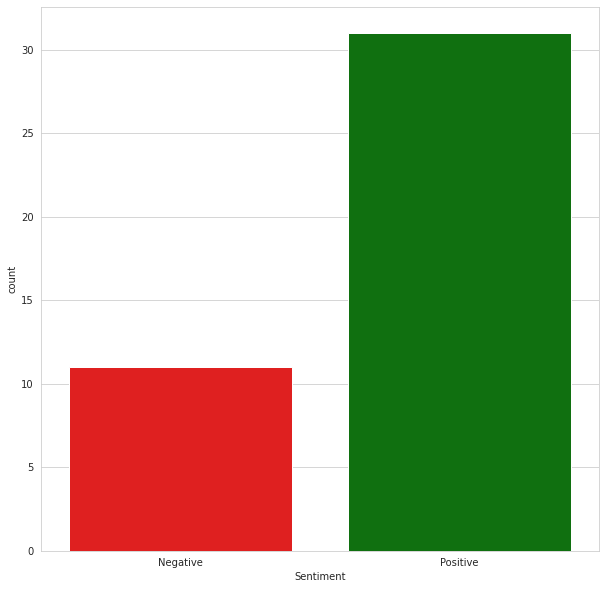

In [128]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment", data=data, 
                  palette=dict(Neutral="blue", Positive="Green", Negative="Red"))

In [129]:
nlp = spacy.load("en_core_web_sm")
def pos(text):
    doc = nlp(text)
    # You want list of Verb tokens 
    aspects = [token.text for token in doc if token.pos_ == "NOUN"]
    return aspects

In [130]:
data["Aspects"] = data['processed_text'].apply(pos)

In [57]:
data.to_csv ('2021_Winter_453_Sec56_Class_Corpus_Updated2.csv', index = False, header=True)
data

,Doc_ID,DSI_Title,Text,processed_text,Polarity,Sentiment,Aspects
0,0,KS_Doc1_2001 Space Odyssey.txt,In the spring of 1964 the filmmaker Stanley Ku...,in the spring of the filmmaker stanley kubrick...,-0.2523,Negative,"[spring, filmmaker, stanley, kubrick, nasa, sp..."
1,1,KS_Doc2_Wargames.txt,I am writing this review on a word processor t...,i am writing this review on a word processor t...,0.9405,Positive,"[review, word, processor, computer, type, sun,..."
2,2,KS_Doc3_The_Matrix.txt,"""The Matrix,"" with Keanu Reeves, Laurence Fish...",the matrix with keanu reeves laurence fishbur...,0.8928,Positive,"[matrix, keanu, reeves, laurence, carrie, anne..."
3,3,KS_Doc4_I_Robot.txt,"'I, Robot"" takes place in Chicago circa 2035, ...",i robot takes place in chicago circa a city w...,-0.9787,Negative,"[robot, place, chicago, circa, city, skyscrape..."
4,4,KS_Doc5_Ex_Machina.txt,"After a recent run ofoverly-hyped, butultimate...",after a recent run ofoverly hyped butultimatel...,0.9974,Positive,"[run, butultimatelydisappointingsci, fi, effor..."
5,5,KS_Doc6_Her.txt,"Spike Jonze's ""Her"" plays like a kind of mirac...",spike jonze s her plays like a kind of miracle...,0.9957,Positive,"[spike, jonze, plays, kind, miracle, time, ope..."
6,6,KS_Doc7_The Terminator.txt,"On Oct. 26, 1984, a newsci-fifranchise was lau...",on oct a newsci fifranchise was launched with ...,0.9650,Positive,"[oct, newsci, fifranchise, u, debut, terminato..."
7,7,PP_Doc1_Disneys_New_Mulan.txt,Title: Disney’s New Mulan Is a Dull Reflection...,title disney s new mulan is a dull reflection ...,0.9973,Positive,"[title, disney, mulan, reflection, publication..."
8,8,PP_Doc2_Cinderella_Review_Straight-Faced.txt,\r\nTitle: Cinderella review – straight-faced ...,title cinderella review straight faced sentim...,0.3973,Positive,"[title, cinderella, review, sentimentality, pu..."
9,9,PP_Doc3_Aladdin_Review_This.txt,Title: ‘Aladdin’ Review: This Is Not What You ...,title aladdin review this is not what you wish...,0.9922,Positive,"[title, aladdin, review, publication, source, ..."


## Classification Models for 2,000 movie review dataset

In [58]:
! pip install spacy==2.2.2
! pip install stanfordnlp==0.2.0
! pip install networkx==2.3

     |████████████████████████████████| 10.3MB 8.3MB/s 
     |████████████████████████████████| 2.2MB 43.7MB/s 
     |████████████████████████████████| 184kB 52.2MB/s 
ERROR: spacy-universal-sentence-encoder 0.4.0 has requirement spacy<4.0.0,>=3.0.0, but you'll have spacy 2.2.2 which is incompatible.
ERROR: en-core-web-sm 3.0.0 has requirement spacy<3.1.0,>=3.0.0, but you'll have spacy 2.2.2 which is incompatible.
ERROR: en-core-web-lg 3.0.0 has requirement spacy<3.1.0,>=3.0.0, but you'll have spacy 2.2.2 which is incompatible.
  Found existing installation: srsly 2.4.0
    Uninstalling srsly-2.4.0:
      Successfully uninstalled srsly-2.4.0
  Found existing installation: thinc 8.0.2
    Uninstalling thinc-8.0.2:
      Successfully uninstalled thinc-8.0.2
  Found existing installation: spacy 3.0.5
    Uninstalling spacy-3.0.5:
      Successfully uninstalled spacy-3.0.5


     |████████████████████████████████| 163kB 12.9MB/s 
     |████████████████████████████████| 1.8MB 12.6MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556408 sha256=d88d9fd24a4001ac053dd3fc363a181709e4a71da3078ce814340e93681d8d01
  Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built networkx
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: networkx 2.5
    Uninstalling networkx-2.5:
      Successfully uninstalled networkx-2.5


In [59]:
###############################################################################
### packages required to run code.  Make sure to install all required packages.
###############################################################################
#  general
import matplotlib.pyplot as plt
import pandas as pd
import os
import string
import numpy as np
import re
import pickle
import warnings


# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import spacy as spacy
nlp = spacy.load("en_core_web_sm")

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [60]:
if 'google.colab' in str(get_ipython()):
    rootpath = "/content/drive/MyDrive"  
else:
    rootpath = "g:/My Drive"  

asg = "/movie_reviews/"

filepath = rootpath + asg
logspath = rootpath + "logs/" + asg
modelspath = filepath + "models/"
objpath = filepath + "objects/"
outputpath = filepath + "output/"

In [61]:
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [62]:
#Section 3, 4, 5: Classifiers
def sklearn_classifiers(X_train, X_test, y_train, y_test, model_type):
    
    #this function is to fit 3 different model scenarios.  Support vector machines, logistic regressions, naive bayes.
    #svm = Support vector machin
    #logistic = Logistic regression
    #naive_bayes = Naive Bayes Multinomial
    
 
    #function returns the train test split scores of each model.
    
    if model_type == 'svm':
        print("svm")
        model = SVC()

    elif model_type == 'logistic':
        print("logistic")
        model = LogisticRegression()

    elif model_type == 'naive_bayes':
        print("naive_bayes")
        model = MultinomialNB() 
    
    model.fit(X_train, y_train)

    
    #NOTE THIS IS AN OVERFIT CASE SO YOU KNOW THAT IT IS WORKING
    #ONCE YOU GET CLOSE TO 100% ACCURACY THEN COMMENT OUT THESE TWO LINES
    #predictions = model.predict(X_train)
    #accy = accuracy_score(y_train, predictions)
    
    #NOTE THIS IS THE CORRECT WAY TO TEST YOUR CLASSIFIERS
    #UNCOMMENT THESE TWO LINES ONCE THE OVERFIT CASE YIELDS CLOSE TO 100% ACCURACY
    predictions = model.predict(X_test)
    accy = accuracy_score(y_test, predictions)
    
    return model, predictions, accy

In [63]:
def process_text(X, min_df=5, bigrams=False):
    documents = []
    from nltk.stem import WordNetLemmatizer

    stemmer = WordNetLemmatizer()

    for sen in range(0, len(X)):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(X[sen]))
        
        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
        
        # Remove single characters from the start
        #document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
        
        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)
        
        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)
        
        # Converting to Lowercase
        document = document.lower()
        
        # Lemmatization
        document = document.split()

        document = [stemmer.lemmatize(word) for word in document]
        document = ' '.join(document)
        
        documents.append(document)

    if bigrams==True:
            tfidfconverter = TfidfVectorizer(max_features=1500, min_df=min_df, ngram_range=(1,2), max_df=0.7, stop_words=stopwords.words('english'))
    else:
            tfidfconverter = TfidfVectorizer(max_features=1500, min_df=min_df, max_df=0.7, stop_words=stopwords.words('english'))


    X = tfidfconverter.fit_transform(documents).toarray()
    words = tfidfconverter.get_feature_names()
    return X, documents, words

In [64]:
def most_informative_feature_for_binary_classification(feature_names, classifier, n=10):
    class_labels = classifier.classes_
    #feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print (class_labels[0], coef, feat)

    print()

    for coef, feat in reversed(topn_class2):
        print (class_labels[1], coef, feat)

def most_informative_feature_for_classification(classifier, document, n=10):

    return words 

In [65]:
# function to get dictionary of features for nltk classifiers
def get_feature(r):
    feature = {}
    #print(r.shape)
    for i, value in enumerate(r):
        #print(i)
        feature[words[i]] = value
    return feature

## Load 2,000 movie review Corpus

### load NLTK polarity data set

In [170]:
dir='/content/drive/MyDrive/txt_sentoken/'

movie_data = load_files(dir)
X, y = movie_data.data, movie_data.target
X, documents, words = process_text(X,  min_df=2, bigrams=True)
class_names=set(y)

In [171]:
X.shape, len(documents), len(words)

((2000, 1500), 2000, 1500)

In [172]:
df = pd.DataFrame(movie_data.data, columns=['text'])
df['text'] = df['text'].str.decode('utf-8')


### Some stats about the data

In [173]:
tokens = df['text'].str.split()
# total number of tokens
token_count = sum([len(l) for l in tokens])
token_count

1492681

In [174]:
all_tokens = []
for l in tokens:
    all_tokens = all_tokens + l

In [175]:
 series = pd.DataFrame(data=all_tokens).value_counts()
 series.head(10)

,      77717
the    76178
.      65876
a      37934
and    35343
of     33970
to     31759
is     25163
in     21591
"      17612
dtype: int64

In [74]:
len(series)

50920

In [176]:
token_count = sum([len(l) for l in tokens])
token_count

1492681

In [177]:
df = pd.DataFrame(data=X)
df.columns = words
tf_idf_corpus = df

In [178]:
# ensure this word is not already in the columns
'NLTKfeatures' in tf_idf_corpus.columns

False

In [179]:
tf_idf_corpus['NLTKfeatures'] = tf_idf_corpus.apply(get_feature, axis=1)

## SKlearn Classifiers

In [180]:
# split the training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [80]:
print(len(X))
print(len(y))

2000
2000


In [81]:
model_svm, y_hat, accy = sklearn_classifiers(X_train, X_test, y_train, y_test,'svm')
accy

svm


0.8212121212121212

In [82]:
def display_confusion_matrix(classifier, X_test, y_test, y_hat,class_names ):
    cm=confusion_matrix(y_test, y_hat)
    np.set_printoptions(precision=2)

    titles_options = [("Confusion matrix, without normalization", None),
                        ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
            disp = plot_confusion_matrix(classifier, X_test, y_test,
                                        display_labels=class_names,
                                        cmap=plt.cm.Blues,
                                        normalize=normalize)
            disp.ax_.set_title(title)
            print(title)
            print(disp.confusion_matrix)

    plt.show()


In [83]:
def model_metrics(y_test, y_hat):
    # Actual = 0 (negative), but predicted = 1 (positive)
    false_positive = np.where((y_test != y_hat) & (y_test ==0))
    print(f'False Positive  count = {len(false_positive[0])}\n {false_positive} \n')

    # Actual = 1 (positive), but predicted = 0 (negative)
    false_negative = np.where((y_test != y_hat) & (y_test ==1))
    print(f'False Negative  count = {len(false_negative[0])}\n {false_negative}')


Confusion matrix, without normalization
[[265  54]
 [ 64 277]]
Normalized confusion matrix
[[0.83 0.17]
 [0.19 0.81]]


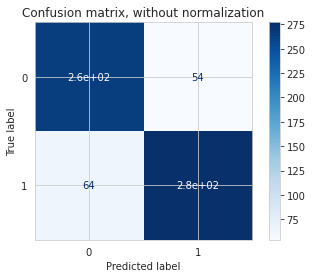

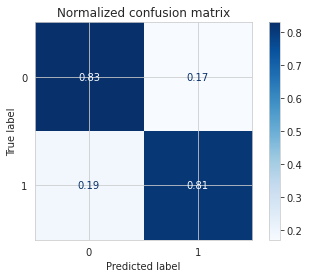

In [84]:
display_confusion_matrix(model_svm, X_test, y_test, y_hat, class_names)

In [85]:
model_metrics(y_test, y_hat)

False Positive  count = 54
 (array([  1,  10,  12,  17,  26,  37,  80,  89, 109, 122, 139, 141, 160,
       164, 171, 173, 177, 178, 198, 238, 258, 278, 293, 296, 310, 313,
       322, 323, 325, 342, 349, 354, 360, 381, 389, 402, 405, 406, 414,
       424, 458, 465, 474, 475, 494, 520, 530, 553, 585, 594, 596, 603,
       640, 643]),) 

False Negative  count = 64
 (array([  0,  16,  38,  64,  67,  75,  81,  83, 107, 108, 132, 169, 170,
       185, 189, 190, 215, 255, 267, 269, 270, 283, 291, 303, 308, 311,
       312, 331, 344, 358, 359, 362, 370, 399, 420, 428, 431, 436, 437,
       447, 449, 452, 455, 481, 485, 492, 506, 508, 515, 531, 550, 559,
       571, 572, 575, 590, 599, 611, 615, 620, 624, 635, 639, 650]),)


In [181]:
txt_lookup={}
for i in range(0,len(documents)):
    txt_lookup[str(X[i])]=documents[i]
#creating datafram from TFIDF Matrix
print(txt_lookup[str(X_test[0])])

apollo 13 is simply one of the most dramatic film this summer apart from swashbuckling braveheart ndirector and former actor ron howard splash backdraft far away most noted for his dramatic film making display again his brilliance in creating drama and suspense in apollo 13 nbeing the second largest box office hit in the u this summer with more than u 150 million in the state alone this film is his most successful effort yet nperhaps one of the most appealing feature of this film is the pool of talented actor such a tom hank gump himself kevin bacon footloose tremor few good men etc gary sinise forrest gump bill paxton alien true lie boxing helena and ed harris the abyss just cause nall of whom gave good performance in their respective role napollo 13 wa the second worst accident ever to occur in the history of u spaceflight the worst being the challenger accident njim lovell hank the mission commander together with his crew fred haise paxton and last minute replacement tom swigert bac

In [87]:
from nltk.metrics import precision,recall,f_measure
import collections

# defaultdict works like a python dict but also adds the key if it does not exist
refsets = collections.defaultdict(set)
testsets = collections.defaultdict(set)

# create a dictionary that has the index of all positive and negative documents
# refsets is the actual class and testset is the predicted class 
for i, label in enumerate(y_test):
    refsets[label].add(i)
    observed = y_hat[i]
    testsets[observed].add(i)

# Uses sets to compute precision and recall
# precision = (refrence ∩ test)/ test
# recall = (reference ∩ test) / reference
#print(refsets)
print('pos precision:', precision(refsets[1], testsets[1]))
print( 'pos recall:', recall(refsets[1], testsets[1]))
print('pos F-measure:', f_measure(refsets[1], testsets[1]))
print('neg precision:', precision(refsets[0], testsets[0]))
print('neg recall:', recall(refsets[0], testsets[0]))
print('neg F-measure:', f_measure(refsets[0], testsets[0]))

pos precision: 0.8368580060422961
pos recall: 0.8123167155425219
pos F-measure: 0.824404761904762
neg precision: 0.8054711246200608
neg recall: 0.8307210031347962
neg F-measure: 0.8179012345679013


In [88]:
modelfile = modelspath + 'model_svm_pol.pickle'
with open(modelfile, mode='wb') as outfile:
    pickle.dump(model_svm, outfile )


In [89]:
model_logit, y_hat, accy = sklearn_classifiers(X_train, X_test, y_train, y_test,'logistic')
accy

logistic


0.8151515151515152

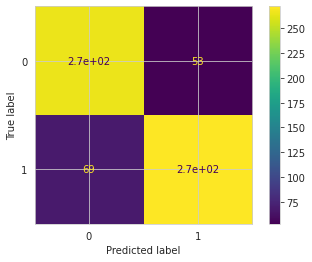

In [90]:
plot_confusion_matrix(model_logit, X_test, y_test)  
plt.show()

In [91]:
modelfile = modelspath + 'model_logit_pol.pickle'
with open(modelfile, mode='wb') as outfile:
    pickle.dump(model_logit, outfile )

In [92]:
most_informative_feature_for_binary_classification(words, model_logit, n=10)

0 -3.0183795080166216 bad
0 -2.0535014499136786 worst
0 -2.046719588144786 plot
0 -1.7501465911675431 supposed
0 -1.635241693894532 script
0 -1.5232536709383573 boring
0 -1.5025787813439366 nothing
0 -1.480090795897062 attempt
0 -1.3054437283151408 stupid
0 -1.3004882089024818 awful

1 2.006509473214591 well
1 1.8109590397196704 great
1 1.7475755603409453 life
1 1.6178856619087232 also
1 1.489546795673507 war
1 1.4402539380782797 performance
1 1.3810217210013598 best
1 1.218634232738987 political
1 1.166735768139537 perfectly
1 1.1381097136937846 fun


In [93]:
logit_coef = sorted(zip(model_logit.coef_[0], words), reverse=True)
df = pd.DataFrame(logit_coef, columns=['coef', 'word'])
logit_coef_df = df
logit_coef_df.to_pickle(objpath + 'polarity_logit_coef.pickle' )


In [94]:
df = pd.DataFrame(logit_coef, columns=['coef', 'word'])

In [95]:
model_nb, predictions, accy = sklearn_classifiers(X_train, X_test, y_train, y_test,'naive_bayes')
accy

naive_bayes


0.793939393939394

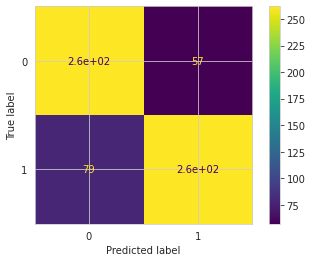

In [96]:
plot_confusion_matrix(model_nb, X_test, y_test)  
plt.show()

In [97]:
modelfile = modelspath + 'model_naive_bayes_pol.pickle'
with open(modelfile, mode='wb') as outfile:
    pickle.dump(model_nb, outfile )

In [98]:
most_informative_feature_for_binary_classification(words, model_nb, n=10)

0 -8.882146507424094 godzilla
0 -8.614468097674749 ridiculous
0 -8.555418241726386 awful
0 -8.548564315138002 wasted
0 -8.529759660606565 poorly
0 -8.528497912954247 specie
0 -8.4775366320544 lame
0 -8.45113782217761 bad movie
0 -8.434951517177524 waste
0 -8.409256199256486 pointless

1 -5.8361651166986 life
1 -5.836474290470502 story
1 -5.846104341301183 nit
1 -5.90393283616781 scene
1 -5.970660258308742 good
1 -5.9808570585419325 get
1 -5.994254350316394 make
1 -6.004413973339101 well
1 -6.011321595638762 also
1 -6.053388884248683 nhe


## Sentiment Analysis using Bi-LSTM

In [182]:
# Utilities
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [183]:
from gensim.models import Word2Vec

Embedding_dimensions = 100
# Defining the model input length.
input_length = 60

In [184]:
# Defining the model input length.
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [192]:
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(documents)

vocab_length = len(tokenizer.word_index) + 1
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 40127


In [193]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

In [194]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [195]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length, 
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix], 
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [196]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 60, 100)           4012700   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 60, 200)           160800    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 60, 200)           240800    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 56, 100)           100100    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_5 (Dense)              (None, 1)             

In [197]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [198]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [199]:
history = training_model.fit(
    X_train, y_train,
    batch_size=200,
    epochs=160,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/160


7/7 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4869 WARNING:tensorflow:Model was constructed with shape (None, 60) for input KerasTensor(type_spec=TensorSpec(shape=(None, 60), dtype=tf.float32, name='embedding_2_input'), name='embedding_2_input', description="created by layer 'embedding_2_input'"), but it was called on an input with incompatible shape (None, 1500).


7/7 [==============================] - 178s 24s/step - loss: 0.6932 - accuracy: 0.4868 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/160
7/7 [==============================] - 160s 22s/step - loss: 0.6932 - accuracy: 0.4802 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/160
7/7 [==============================] - 181s 26s/step - loss: 0.6931 - accuracy: 0.5072 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/160
7/7 [==============================] - 171s 24s/step - loss: 0.6931 - accuracy: 0.5150 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/160
7/7 [==============================] - 176s 24s/step - loss: 0.6931 - accuracy: 0.5137 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/160
7/7 [==============================] - 172s 24s/step - loss: 0.6931 - accuracy: 0.5110 - val_loss: 0.6932 - val_accuracy: 0.5000


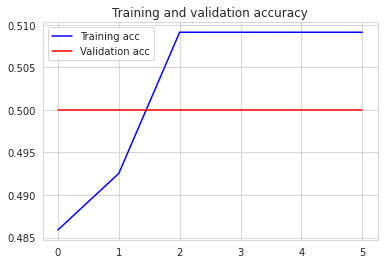

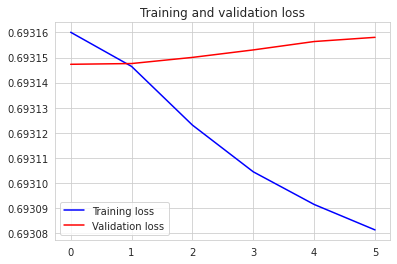

In [200]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [201]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

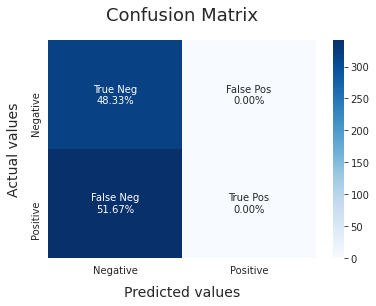

In [202]:
# Predicting on the Test Dataset
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

In [203]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      1.00      0.65       319
           1       0.00      0.00      0.00       341

    accuracy                           0.48       660
   macro avg       0.24      0.50      0.33       660
weighted avg       0.23      0.48      0.31       660



## NLTK Clasifiers

In [99]:
featuresets = [(f, y[i]) for i, f in enumerate (tf_idf_corpus['NLTKfeatures'])]

In [100]:
training_set = featuresets[:1900]
testing_set = featuresets[1900:]

In [101]:
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [102]:
print("Naive bayes algo accurcy:", (nltk.classify.accuracy(classifier, testing_set))*100)

Naive bayes algo accurcy: 60.0


In [103]:
classifier.show_most_informative_features(15)

Most Informative Features
                     bad = 0.0                 1 : 0      =      1.5 : 1.0
             performance = 0.0                 0 : 1      =      1.3 : 1.0
                    plot = 0.0                 1 : 0      =      1.3 : 1.0
                    life = 0.0                 0 : 1      =      1.3 : 1.0
                    well = 0.0                 0 : 1      =      1.3 : 1.0
                      ni = 0.0                 1 : 0      =      1.3 : 1.0
                    also = 0.0                 0 : 1      =      1.3 : 1.0
                    best = 0.0                 0 : 1      =      1.2 : 1.0
                     see = 0.0                 0 : 1      =      1.2 : 1.0
                   world = 0.0                 0 : 1      =      1.2 : 1.0
                   great = 0.0                 0 : 1      =      1.2 : 1.0
                   worst = 0.0                 1 : 0      =      1.2 : 1.0
                  script = 0.0                 1 : 0      =      1.2 : 1.0

## Class Corpus sentiment


### Load Class Corpus

In [148]:
#load class corpus
path_to_file= filepath + '2021_Winter_453_Sec56_Class_Corpus_Updated2.csv'
data=pd.read_csv(path_to_file)
title = data['DSI_Title']
text = list(data['Text'])
#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))
data_unprocessed=data['Text']
#final_processed_text = [' '.join(x) for x in data['processed_text']]
titles = data['DSI_Title'].tolist()

In [149]:
X_class_corpus, documents_class_corpus, features_class_corpus = process_text(text, min_df=2)

## Classification Using Bi-LSTM & SVM & Logistic Regression & Naive Bayes Models

In [ ]:
data['svm'] = model_svm.predict(X_class_corpus)
data['logit'] = model_logit.predict(X_class_corpus)
data['naive_bayes'] = model_nb.predict(X_class_corpus)

In [ ]:
df = data[['processed_text','Sentiment']]
# convert movie review VADER labeled seentiment to numeric values
y_class_corpus = df.sentiment.factorize()

X_train, X_test, y_train, y_test = train_test_split(X_class_corpus, y_class_corpus, test_size=0.2, random_state=0)

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd

history = training_model.fit(
    X_train, y_train,
    batch_size=200,
    epochs=10,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1,
)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 200, 32)           187648    
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 200, 32)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 51        
Total params: 204,299
Trainable params: 204,299
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.6927 - accuracy: 0.5152 - val_loss: 0

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

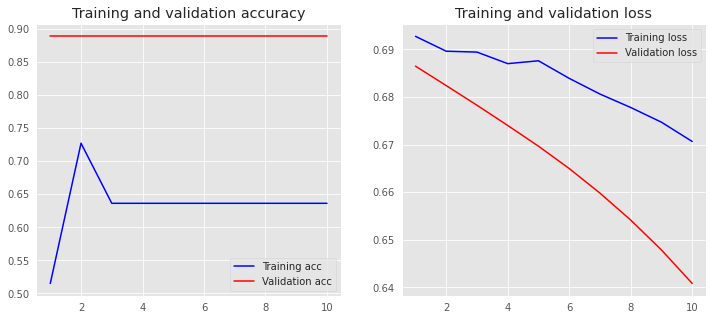

In [ ]:
plot_history(history)

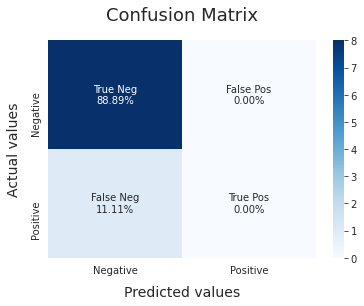

In [ ]:
# Predicting on the Test Dataset
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

In [ ]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.00      0.00      0.00         1

    accuracy                           0.89         9
   macro avg       0.44      0.50      0.47         9
weighted avg       0.79      0.89      0.84         9



In [169]:
y = training_model.predict(X_class_corpus)
y = np.argmax(y, axis=1)
data['Bi-LSTM'] = y
data.to_csv ('sentiment.csv', index = False, header=True)

## Determine key words based on the above predictors 

## Based on above models create labeled Data set for the class corpus. 

In [ ]:
y_class_corpus = data['logit'].to_numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_class_corpus, y_class_corpus, test_size=0.2, random_state=0)

In [ ]:
X_train.shape,X_test.shape

((33, 1500), (9, 1500))

In [ ]:
model_svm, y_hat, accy = sklearn_classifiers(X_train, X_test, y_train, y_test ,'svm')
accy

svm


0.7777777777777778

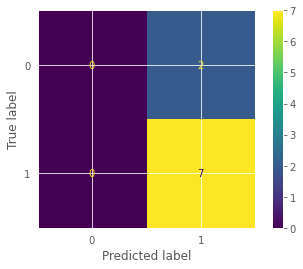

In [ ]:
plot_confusion_matrix(model_svm, X_test, y_test)  
plt.show()

In [ ]:
model_logit, y_hat, accy = sklearn_classifiers(X_train, X_test, y_train, y_test ,'logistic')
accy

logistic


0.7777777777777778

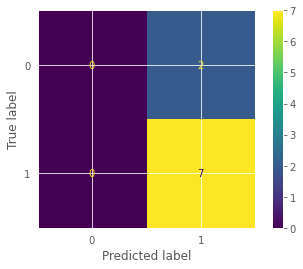

In [ ]:
plot_confusion_matrix(model_logit, X_test, y_test)  
plt.show()

In [ ]:
most_informative_feature_for_binary_classification(features_class_corpus, model_logit, n=10)

0 -0.5211564510807193 ford
0 -0.3054758218366443 india
0 -0.29336977199480013 washington
0 -0.2872924321666823 red
0 -0.28678161427340537 october
0 -0.28377182298426995 cia
0 -0.25985653269186404 captain
0 -0.22922946714474657 hunt
0 -0.2148227104866178 reality
0 -0.19359641086174778 stone

1 0.3218542239605879 robot
1 0.2872134520045908 site
1 0.28403099912558794 link
1 0.28403099912558794 external
1 0.24675042720393647 paris
1 0.22689249845734125 carter
1 0.1826594219883004 alice
1 0.17516668014118905 turing
1 0.16922309441269323 jungle
1 0.16549873534707424 story


In [ ]:
model_nb, predictions, accy = sklearn_classifiers(X_train, X_test, y_train, y_test ,'naive_bayes')
accy

naive_bayes


0.7777777777777778

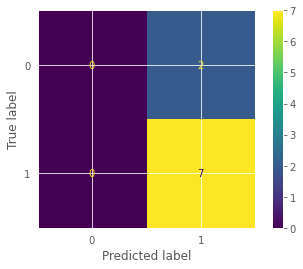

In [ ]:
plot_confusion_matrix(model_nb, X_test, y_test)  
plt.show()

In [ ]:
most_informative_feature_for_binary_classification(features_class_corpus, model_nb, n=10)

0 -7.428097788563016 13
0 -7.428097788563016 2007
0 -7.428097788563016 5th
0 -7.428097788563016 ability
0 -7.428097788563016 aboard
0 -7.428097788563016 accepted
0 -7.428097788563016 across
0 -7.428097788563016 acting
0 -7.428097788563016 added
0 -7.428097788563016 admirer

1 -6.5171862480021145 link
1 -6.5171862480021145 external
1 -6.524509654337906 site
1 -6.747122323016045 robot
1 -6.821523969527449 wa
1 -6.846271008073575 computer
1 -6.848705931524994 story
1 -6.876605386285523 paris
1 -6.87793208789448 disney
1 -6.930302336931296 man
